In [ ]:
!pip install gluonts
!pip install autogluon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to 

In [ ]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.metrics import mse
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

ModuleNotFoundError: No module named 'gluonts'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')
df = df[df.unique_id == "BE"]
df

,unique_id,ds,y
0,BE,2016-10-22 00:00:00,70.00
1,BE,2016-10-22 01:00:00,37.10
2,BE,2016-10-22 02:00:00,37.10
3,BE,2016-10-22 03:00:00,44.75
4,BE,2016-10-22 04:00:00,37.10
...,...,...,...
1675,BE,2016-12-30 19:00:00,57.42
1676,BE,2016-12-30 20:00:00,57.56
1677,BE,2016-12-30 21:00:00,52.18
1678,BE,2016-12-30 22:00:00,54.38


In [ ]:
# Initialize variables
historical_days = 21
window_size = 24 * historical_days  # 24 hours a day
prediction_length = 24  # Predict 24 hours

pred_dict = {}
actual_dict = {}
best_model_name = []

# Iterate through the time series data by rolling window
for start_idx in range(len(df) - window_size):
    # Slice the data for the current rolling window
    rolling_window = df.iloc[start_idx : start_idx + window_size]

    # Convert rolling_window to a TimeSeriesDataFrame
    train_data = TimeSeriesDataFrame.from_data_frame(
        rolling_window,
        id_column='unique_id',  # Specify the item_id column
        timestamp_column='ds'  # Specify the timestamp column
    )

    # Fit the TimeSeriesPredictor on the rolling window
    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        path="multiple-timeseries/electric-hourly-1week_rollingwindow",
        freq="H",
        target="y",
        eval_metric="MSE",
    )
    predictor.fit(train_data, presets="fast_training", random_seed=42)

    # Predict the next hour
    prediction = predictor.predict(train_data, random_seed=42)

    # Add the predictions to the list
    pred_dict[df.iloc[start_idx + window_size].ds] = prediction['mean'].to_list()
    actual_dict[df.iloc[start_idx + window_size].ds] = df.iloc[start_idx + window_size].y

    best_model_name.append(predictor.info()["best_model"])

Streaming output truncated to the last 5000 lines.
	0.45    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. 
	-70.5821      = Validation score (-MSE)
	0.81    s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Training timeseries model ETS. 
	-193.5140     = Validation score (-MSE)
	0.02    s     = Training runtime
	0.37    s     = Validation (prediction) runtime
Training timeseries model Theta. 
	-148.8133     = Validation score (-MSE)
	0.02    s     = Training runtime
	0.13    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DirectTabular': 1.0}
	-70.5821      = Validation score (-MSE)
	0.90    s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Training complete. Models trained: ['Naive', 'SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'ETS', 'Theta', 'WeightedEnsemble']
Total runtime: 4.53 s
Best model: DirectTabular
Best model score: -70.5821
Model not 

In [ ]:
# Assuming pred_dict is defined as in the original code
# Create an empty list to store the data for the DataFrame
data_pred = []

# Iterate through the pred_dict
for date, predictions in pred_dict.items():
  # Create a dictionary for each date's predictions
  row = {'time': date}
  for i, pred in enumerate(predictions):
    row[f'step{i+1}'] = pred
  data_pred.append(row)

# Create the DataFrame
pred_df = pd.DataFrame(data_pred)

actual_df = pd.DataFrame(list(actual_dict.items()), columns=['time', 'actual'])

# Convert 'time' column to datetime objects if they are not already
actual_df['time'] = pd.to_datetime(actual_df['time'])
pred_df['time'] = pd.to_datetime(pred_df['time'])

# Merge the DataFrames on the 'time' column
merged_df = pd.merge(actual_df, pred_df, on='time', how='inner')
merged_df['best_model'] = best_model_name
merged_df

,time,actual,step1,step2,step3,step4,step5,step6,step7,step8,...,step16,step17,step18,step19,step20,step21,step22,step23,step24,best_model
0,2016-11-12 00:00:00,59.09,54.789240,53.268665,51.872154,51.199527,50.867871,51.384061,54.962749,60.832540,...,56.141817,58.461459,64.305684,78.309888,73.400918,64.445265,56.772401,56.117309,55.519440,WeightedEnsemble
1,2016-11-12 01:00:00,56.26,54.568783,53.058296,52.624831,51.482928,52.137301,54.096025,58.379471,61.047568,...,56.929377,64.010332,65.418525,63.080797,59.466230,56.231277,55.253623,54.948005,55.331637,WeightedEnsemble
2,2016-11-12 02:00:00,49.70,50.153591,50.016110,49.324119,49.507533,50.441709,57.030356,58.954392,58.978686,...,64.175192,65.669595,65.235879,59.927525,54.527850,53.743814,54.235929,55.065573,54.383173,WeightedEnsemble
3,2016-11-12 03:00:00,46.47,47.674803,46.930779,47.640849,49.067524,55.644685,57.940619,58.335768,58.210763,...,64.629271,63.667637,58.570110,53.311737,52.856385,52.369194,53.474738,52.212363,49.848149,WeightedEnsemble
4,2016-11-12 04:00:00,43.80,46.901269,47.019885,48.087079,54.872400,56.935588,57.309293,57.522167,56.986045,...,63.896160,58.322230,51.707251,51.544498,51.160341,52.056221,51.289397,49.572723,47.338893,WeightedEnsemble
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,2016-12-30 19:00:00,57.42,56.454524,51.014838,47.340869,48.132250,47.359177,41.540922,39.704196,39.060328,...,53.293836,53.507993,52.030902,50.166686,48.858035,50.817689,52.994516,59.137911,59.266420,WeightedEnsemble
1172,2016-12-30 20:00:00,57.56,52.088328,48.392038,49.246244,48.149366,44.483711,43.188794,42.441659,41.363749,...,55.246372,53.804566,51.993214,50.881791,52.520846,54.729432,60.957186,60.475246,57.265499,WeightedEnsemble
1173,2016-12-30 21:00:00,52.18,51.965806,52.928402,50.081820,49.168607,47.859025,45.338160,45.149733,43.843228,...,53.199846,49.920581,50.266304,52.870164,55.369302,62.180424,61.053716,57.686805,57.656102,WeightedEnsemble
1174,2016-12-30 22:00:00,54.38,47.894876,45.432537,45.046162,44.847383,42.294348,41.615539,41.058403,41.986254,...,48.719584,49.551558,53.084025,55.853796,63.323725,61.493262,57.535215,57.114006,52.154038,WeightedEnsemble


In [ ]:
#merged_df.to_pickle('/content/drive/My Drive/autogluon_elec_BE_C3w_P1h_pred.pkl')

NameError: name 'merged_df' is not defined

In [ ]:
import pandas as pd

#Predictions from Auto-gluon
pred_autogluon = pd.read_pickle('/content/drive/My Drive/autogluon_elec_BE_C3w_P1h_pred.pkl')
pred_autogluon.drop(columns = ['actual'], inplace = True)

#predictions from Lag-LLama model
pred_lagllama = pd.read_pickle('/content/drive/My Drive/lag_llama_elec_BE_C3w_P24h_pred.pkl')

# Merge the two dataframes
merged_df = pd.merge(pred_lagllama, pred_autogluon, on='time', suffixes=('_lagllama', '_autogluon'))

In [ ]:
from sklearn.metrics import mean_squared_error

# Initialize list to store the differences
mse_lagllama = []
mse_autogluon = []
mse_avg = []
mse_04l_06a = []
mse_025l_075a = []
mse_075l_025a = []
mse_max = []
mse_min = []

# Loop through the prediction steps (1 to 24)
for x in range(1, 25):
    # Calculate the differences
    temp = merged_df.copy()
    temp['actual_lag'] = merged_df['actual'].shift(-x+1)
    temp['avg'] = (merged_df[f'step{x}_lagllama'] + merged_df[f'step{x}_autogluon']) / 2
    temp['0.4l_0.6a'] = merged_df[f'step{x}_lagllama'] * 0.4 + merged_df[f'step{x}_autogluon'] * 0.6
    temp['0.25l_0.75a'] = merged_df[f'step{x}_lagllama'] * 0.25 + merged_df[f'step{x}_autogluon'] * 0.75
    temp['0.75l_0.25a'] = merged_df[f'step{x}_lagllama'] * 0.75 + merged_df[f'step{x}_autogluon'] * 0.25
    #temp_max = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']].max(axis=1)
    #temp_min = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']].min(axis=1)

    if x == 1:
      temp2 = temp
    else:
      temp2 = temp.iloc[:(-x+1)]

    mse_lagllama.append(mean_squared_error(temp2[f'step{x}_lagllama'], temp2['actual_lag']))
    mse_autogluon.append(mean_squared_error(temp2[f'step{x}_autogluon'], temp2['actual_lag']))
    mse_avg.append(mean_squared_error(temp2['avg'], temp2['actual_lag']))
    mse_04l_06a.append(mean_squared_error(temp2['0.4l_0.6a'], temp2['actual_lag']))
    mse_025l_075a.append(mean_squared_error(temp2['0.25l_0.75a'], temp2['actual_lag']))
    mse_075l_025a.append(mean_squared_error(temp2['0.75l_0.25a'], temp2['actual_lag']))

    """
    mse_lagllama.append(np.nanmean(merged_df[f'step{x}_lagllama'] - temp_actual_lag)**2)
    mse_autogluon.append(np.nanmean(merged_df[f'step{x}_autogluon'] - temp_actual_lag)**2)
    mse_avg.append(np.nanmean(temp_avg - temp_actual_lag)**2)
    mse_max.append(np.nanmean(temp_max - temp_actual_lag)**2)
    mse_min.append(np.nanmean(temp_min - temp_actual_lag)**2)
    """

print(f"MSE for LagLLama: {mse_lagllama}")
print(f"MSE for AutoGluon: {mse_autogluon}")
print(f"MSE for Average Difference: {mse_avg}")
#print(f"MSE for Max Difference: {mse_max}")
#print(f"MSE for Min Difference: {mse_min}")


MSE for LagLLama: [816.119140625, 825.7695922851562, 839.1499633789062, 854.5814208984375, 881.6107788085938, 862.5725708007812, 906.6947631835938, 922.4793701171875, 915.3873291015625, 909.4524536132812, 913.1307983398438, 916.0345458984375, 926.90380859375, 915.5399780273438, 928.0980224609375, 911.099365234375, 927.8679809570312, 935.9520874023438, 938.9622192382812, 943.3795166015625, 928.4973754882812, 935.4461059570312, 932.364501953125, 938.4749755859375]
MSE for AutoGluon: [719.4137586920134, 777.5408321729891, 837.7633536155844, 826.7116994336009, 869.1724696241719, 870.008049878243, 865.7984863604474, 875.6052144445418, 877.5169860736803, 884.5064164343577, 907.6036920118622, 924.1249923993737, 928.3098550896905, 951.2714622121239, 975.1318599123539, 985.2963093253525, 990.4174571476333, 1000.077030596235, 1008.3975120552052, 1001.4796374529594, 981.6484459169523, 963.6665480723956, 988.910218401925, 945.9462373016892]
MSE for Average Difference: [634.3042910101665, 664.78188

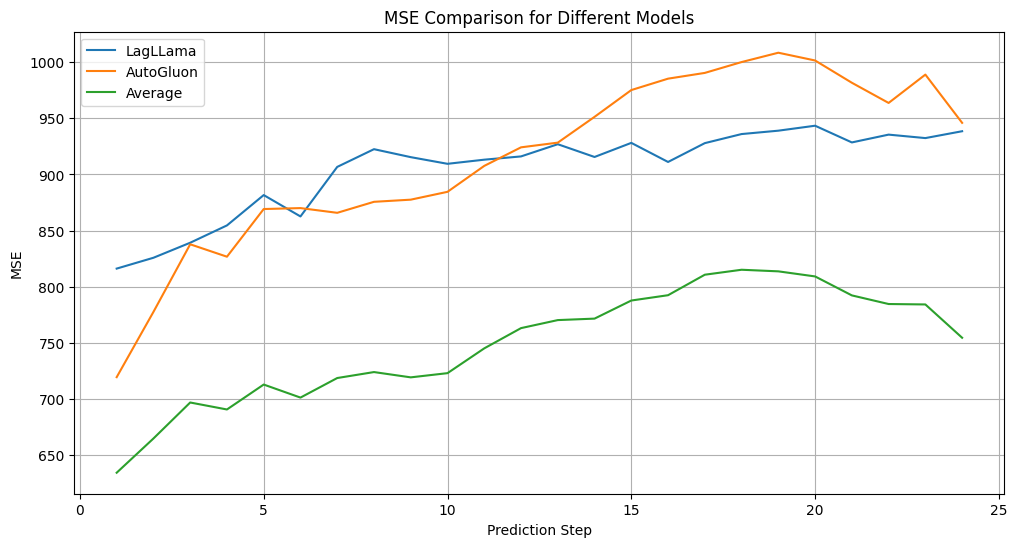

In [ ]:
# Assuming mse_lagllama, mse_autogluon, mse_avg, mse_max, and mse_min are defined as in the previous code
x_axis = list(range(1, 25))

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(x_axis, mse_lagllama, label='LagLLama')
plt.plot(x_axis, mse_autogluon, label='AutoGluon')
plt.plot(x_axis, mse_avg, label='Average')

plt.xlabel('Prediction Step')
plt.ylabel('MSE')
plt.title('MSE Comparison for Different Models')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

mse_cv_min_step = []
mse_cv_max_step = []
mse_cv_avg_step = []
mse_train_step = []
mse_test_step = []
mse_overall_step = []
coeff_lagllama_step = []
coeff_autogluon_step = []

for x in range(1, 25):
  # Prepare the data for the regression model
  if x == 1:
    X = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']]
    y = merged_df['actual']
  else:
    X = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']].iloc[:(-x+1)]
    y = merged_df['actual'].shift(-x+1).iloc[:(-x+1)]

  # Split the data into training and testing sets
  X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # Important: shuffle=False to maintain time order

  # Define the time series cross-validation
  tscv = TimeSeriesSplit(n_splits=5)

  # Initialize lists to store results
  mse_scores = []

  # Perform cross-validation
  for train_index, val_index in tscv.split(X_cv):
      X_train, X_val = X_cv.iloc[train_index], X_cv.iloc[val_index]
      y_train, y_val = y_cv.iloc[train_index], y_cv.iloc[val_index]

      # Initialize and train the linear regression model
      model = LinearRegression(fit_intercept = False)
      model.fit(X_train, y_train)

      # Make predictions on the test set
      y_val_pred = model.predict(X_val)

      # Calculate MSE and store results
      mse = mean_squared_error(y_val, y_val_pred)
      mse_scores.append(mse)

  # Print the average MSE across all folds
  avg_mse = np.mean(mse_scores)
  min_mse = np.min(mse_scores)
  max_mse = np.max(mse_scores)
  mse_cv_avg_step.append(avg_mse)
  mse_cv_min_step.append(min_mse)
  mse_cv_max_step.append(max_mse)
  #print(f"Average MSE across folds: {avg_mse}")

  #train model on overall train data (cv)
  model = LinearRegression(fit_intercept = False)
  model.fit(X_cv, y_cv)

  coefficients = model.coef_
  coeff_lagllama_step.append(coefficients[0])
  coeff_autogluon_step.append(coefficients[1])

  #mse on overall data
  y_cv_pred = model.predict(X_cv)
  mse_train = mean_squared_error(y_cv, y_cv_pred)
  #print(f"MSE on overall train data: {mse_train}")
  mse_train_step.append(mse_train)

  #test the model on test data
  y_test_pred = model.predict(X_test)
  mse_test = mean_squared_error(y_test, y_test_pred)
  mse_test_step.append(mse_test)
  #print(f"MSE on test data: {mse_test}")

  #mse on complete data
  y_pred = model.predict(X)
  mse_overall = mean_squared_error(y, y_pred)
  mse_overall_step.append(mse_overall)
  #print(f"MSE on complete data: {mse_overall}")

In [ ]:
# Create a DataFrame from the lists
coeff_df = pd.DataFrame({
    'step': range(1, 25),
    'coeff_lagllama': coeff_lagllama_step,
    'coeff_autogluon': coeff_autogluon_step
})

coeff_df.to_pickle('/content/drive/My Drive/be_ensemble_coeff_3w.pkl')

In [ ]:
print(f"mse_overall_step: {mse_overall_step}")
print(f"coeff_lagllama_step: {coeff_lagllama_step}")
print(f"coeff_autogluon_step: {coeff_autogluon_step}")

mse_overall_step: [628.594260951182, 663.7436494498569, 696.8842116029942, 690.160537617261, 712.4399084953903, 701.230893731423, 717.1751879517732, 722.3268908705455, 718.2978389233333, 722.6192190092838, 745.0113886370617, 763.158426651027, 770.4013603752334, 771.3387730572585, 787.1954990319324, 790.939343209147, 809.7382967399949, 813.9936338321359, 812.4180059204666, 808.3749129592878, 791.8061621829232, 784.7485247714393, 783.5737211600592, 754.0089954252683]
coeff_lagllama_step: [np.float64(0.40466199632026983), np.float64(0.4651803420900951), np.float64(0.509311229104607), np.float64(0.482037532900585), np.float64(0.4923468115981361), np.float64(0.5128417534601114), np.float64(0.4633902213355201), np.float64(0.4602774342718997), np.float64(0.4715236986864112), np.float64(0.48377098065342716), np.float64(0.49901880433470547), np.float64(0.5132983180413361), np.float64(0.5085187774045045), np.float64(0.5387773584559388), np.float64(0.5493875166638686), np.float64(0.58541085007317

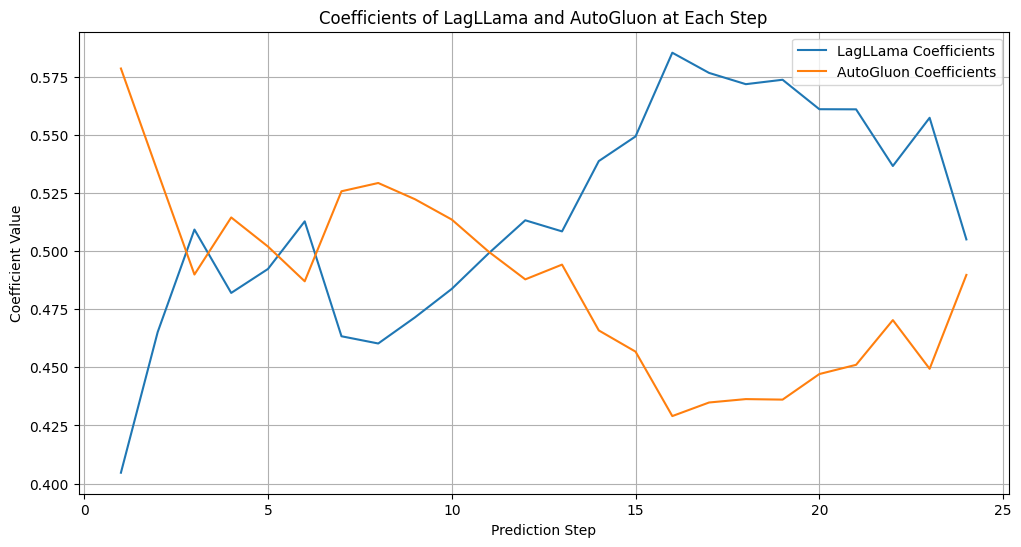

In [ ]:
#plot the co-efficients as line plot for lagllama and autogluon at each step
x_axis = list(range(1, 25))

plt.figure(figsize=(12, 6))
plt.plot(x_axis, coeff_lagllama_step, label='LagLLama Coefficients')
plt.plot(x_axis, coeff_autogluon_step, label='AutoGluon Coefficients')

plt.xlabel('Prediction Step')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of LagLLama and AutoGluon at Each Step')
plt.legend()
plt.grid(True)
plt.show()

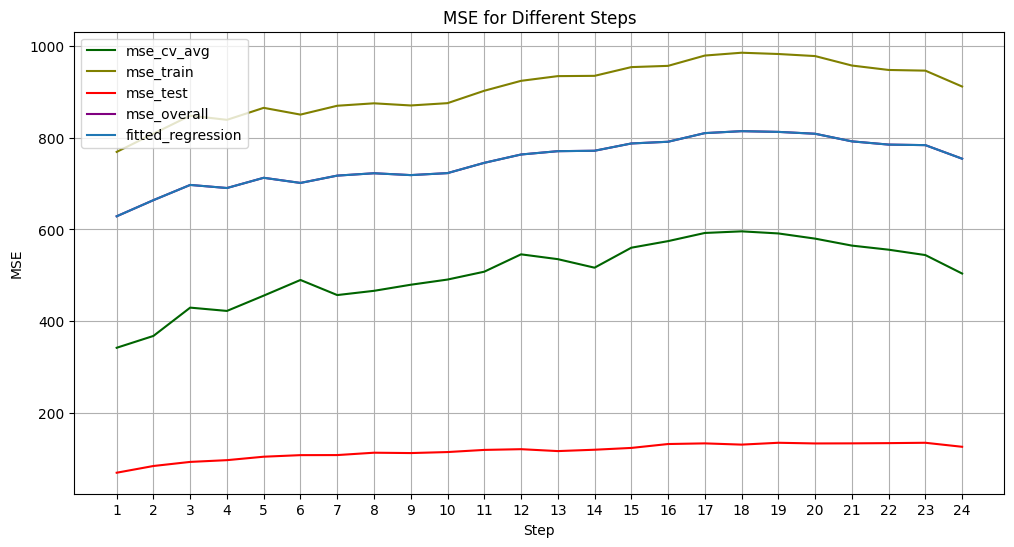

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))

#plt.fill_between(range(1,25), mse_cv_min_step, mse_cv_max_step, color='lightgreen', alpha=0.2)
plt.plot(range(1, 25), mse_cv_avg_step, color='darkgreen', label='mse_cv_avg')
plt.plot(range(1, 25), mse_train_step, color='olive', label='mse_train')
plt.plot(range(1, 25), mse_test_step, color='red', label='mse_test')
plt.plot(range(1, 25), mse_overall_step, color='purple', label='mse_overall')


# Customize the plot
plt.xlabel('Step')
plt.ylabel('MSE')
plt.title('MSE for Different Steps')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 25))
plt.show()

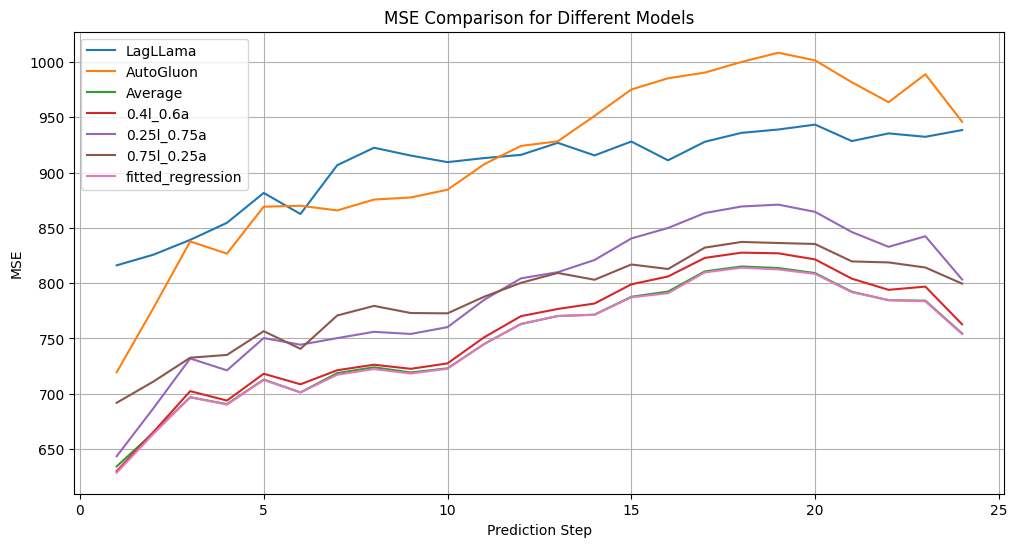

In [ ]:
import matplotlib.pyplot as plt

# Assuming mse_lagllama, mse_autogluon, mse_avg, mse_max, and mse_min are defined as in the previous code
x_axis = list(range(1, 25))

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(x_axis, mse_lagllama, label='LagLLama')
plt.plot(x_axis, mse_autogluon, label='AutoGluon')
plt.plot(x_axis, mse_avg, label='Average')
plt.plot(x_axis, mse_04l_06a, label='0.4l_0.6a')
plt.plot(x_axis, mse_025l_075a, label='0.25l_0.75a')
plt.plot(x_axis, mse_075l_025a, label='0.75l_0.25a')
plt.plot(x_axis, mse_overall_step, label='fitted_regression')
#plt.plot(x_axis, mse_max, label='Max')
#plt.plot(x_axis, mse_min, label='Min')

plt.xlabel('Prediction Step')
plt.ylabel('MSE')
plt.title('MSE Comparison for Different Models')
plt.legend()
plt.grid(True)
plt.show()